# SpikeInterface pipeline for Tank Lab

In [1]:
import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib notebook

## 1) Load AP recordings, LF recordings and TTL signals

In [ ]:
#base_path = Path("/Users/abuccino/Documents/Data/catalyst/brody/A256_bank1_2020_09_30_g0")
base_data_path = Path("D:/Neuropixels/Neuropixels/A256_bank1_2020_09_30/A256_bank1_2020_09_30_g0")
ap_bin_path = base_data_path / "A256_bank1_2020_09_30_g0_t0.imec0.ap.bin"
lf_bin_path = base_data_path / "A256_bank1_2020_09_30_g0_t0.imec0.lf.bin"

In [3]:
recording_folder = ap_bin_path.parent

### Make spikeinterface folders

In [4]:
spikeinterface_folder = recording_folder / 'spikeinterface'
spikeinterface_folder.mkdir(parents=True, exist_ok=True)

In [5]:
recording_ap = se.SpikeGLXRecordingExtractor(ap_bin_path)

nChan: 385, nFileSamp: 18903100


In [6]:
recording_lf = se.SpikeGLXRecordingExtractor(lf_bin_path)

nChan: 385, nFileSamp: 1575259


In [7]:
print(f"Sampling frequency AP: {recording_ap.get_sampling_frequency()}")
print(f"Sampling frequency LF: {recording_lf.get_sampling_frequency()}")      

Sampling frequency AP: 30000.168947
Sampling frequency LF: 2500.0140789166667


### Load TTL signals

In [8]:
ttl, states = recording_ap.get_ttl_events()
rising_times = ttl[states==1]

In [9]:
start_time = recording_ap.frame_to_time(rising_times[0])

In [10]:
start_frame_ap = int(recording_ap.time_to_frame(start_time))
start_frame_lf = int(recording_lf.time_to_frame(start_time))
print(f"Start frame AP: {start_frame_ap}")
print(f"Start frame LF: {start_frame_lf}")    

Start frame AP: 15331
Start frame LF: 1278


### Synchronize recording

In [11]:
recording_ap_sync = se.SubRecordingExtractor(recording_ap, start_frame=start_frame_ap)
recording_lf_sync = se.SubRecordingExtractor(recording_lf, start_frame=start_frame_lf)

### Inspect signals

<IPython.core.display.Javascript object>


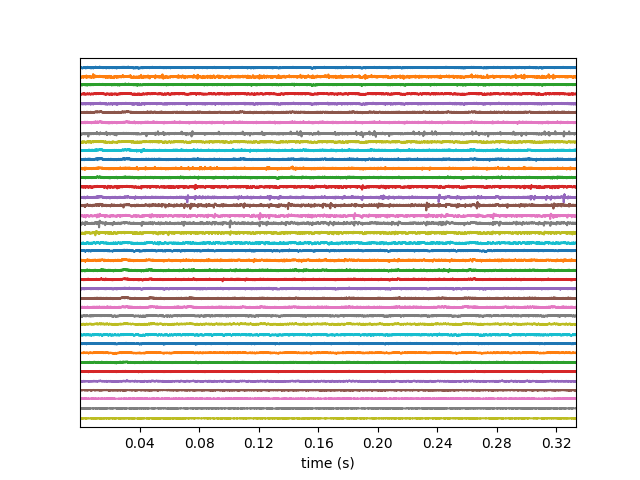

In [12]:
w_ts_ap = sw.plot_timeseries(recording_ap, channel_ids=recording_ap.get_channel_ids()[::10])

<IPython.core.display.Javascript object>


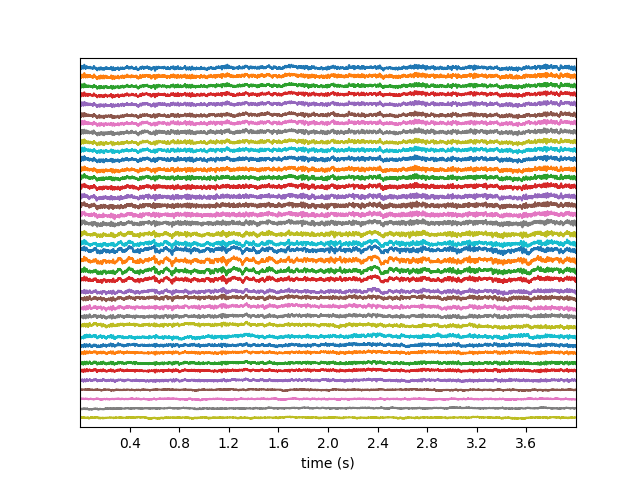

In [13]:
w_ts_lf = sw.plot_timeseries(recording_lf, channel_ids=recording_lf.get_channel_ids()[::10])

## 2) Pre-processing

In [14]:
apply_cmr = True

In [15]:
if apply_cmr:
    recording_processed = st.preprocessing.common_reference(recording_ap_sync)
else:
    recording_processed = recording_ap_sync

In [16]:
num_frames = recording_processed.get_num_frames()

## 3) Run spike sorters

In [17]:
sorter_list = ['kilosort2', 'ironclust', 'spykingcircus']

In [18]:
# Inspect sorter-specific parameters and defaults
for sorter in sorter_list:
    print(f"{sorter} params description:")
    pprint(ss.get_params_description(sorter))
    print("Default params:")
    pprint(ss.get_default_params(sorter))    

kilosort2 params description:
{'NT': 'Batch size (if None it is automatically computed)',
 'Nfilt': 'Number of clusters to use (if None it is automatically computed)',
 'car': 'Enable or disable common reference',
 'detect_threshold': 'Threshold for spike detection',
 'freq_max': 'Low-pass filter cutoff frequency',
 'freq_min': 'High-pass filter cutoff frequency',
 'keep_good_only': "If True only 'good' units are returned",
 'minFR': 'Minimum spike rate (Hz), if a cluster falls below this for too long '
          'it gets removed',
 'minfr_goodchannels': "Minimum firing rate on a 'good' channel",
 'nPCs': 'Number of PCA dimensions',
 'nfilt_factor': 'Max number of clusters per good channel (even temporary '
                 'ones) 4',
 'ntbuff': 'Samples of symmetrical buffer for whitening and spike detection',
 'preclust_threshold': 'Threshold crossings for pre-clustering (in PCA '
                       'projection space)',
 'projection_threshold': 'Threshold on projections',
 'sigma

In [20]:
# user-specific parameters
sorter_params = dict(
    kilosort2=dict(car=False),
    ironclust=dict(),
    spykingcircus=dict()
)

In [23]:
sorting_outputs = ss.run_sorters(
    sorter_list=sorter_list, 
    recording_dict_or_list=dict(rec0=recording_ap),
    working_folder=recording_folder / "working",
    sorter_params=sorter_params
)

Warning! The recording is already filtered, but Ironclust filter is enabled. You can disable filters by setting 'filter' parameter to False
RUNNING SHELL SCRIPT: D:\Neuropixels\Neuropixels\A256_bank1_2020_09_30\A256_bank1_2020_09_30_g0\working\rec0\ironclust\run_ironclust.bat


KeyboardInterrupt: 

## 4) Post-processing: extract waveforms, templates, quality metrics, extracellular features

### Set postprocessing parameters

In [ ]:
# Post-processing params
postprocessing_params = st.postprocessing.get_common_params()
pprint(postprocessing_params)

In [ ]:
# (optional) change parameters
postprocessing_params['max_spikes_per_unit'] = 1000  # with None, all waveforms are extracted

### Set quality metric list

In [ ]:
# Quality metrics
qc_list = st.validation.get_quality_metrics_list()
print(f"Available quality metrics: {qc_list}")

In [ ]:
# (optional) define subset of qc
qc_list = ['snr', 'isi_violation', 'firing_rate']

### Set extracellular features

In [ ]:
# Extracellular features
ec_list = st.postprocessing.get_template_features_list()
print(f"Available EC features: {ec_list}")

In [ ]:
# (optional) define subset of ec
ec_list = ['peak_to_valley', 'halfwidth']

### Postprocess all sorting outputs

In [ ]:
st.validation.compute_quality_metrics?

In [ ]:
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    tmp_folder = spikeinterface_folder / 'tmp' / sorter
    tmp_folder.mkdir(parents=True)
    
    # set local tmp folder
    sorting.set_tmp_folder(tmp_folder)
    
    # compute waveforms
    waveforms = st.postprocessing.get_unit_waveforms(recording_processed, sorting, **postprocessing_params)
    
    # compute templates
    templates = st.postprocessing.get_unit_templates(recording_processed, sorting, **postprocessing_params)
    
    # comput EC features
    ec = st.postprocessing.compute_unit_template_features(recording_processed, sorting,
                                                          feature_names=ec_list, as_dataframe=True)
    # compute QCs
    qc = st.validation.compute_quality_metrics(sorting, recording=recording_processed, 
                                               metric_names=qc_list, as_dataframe=True)
    
    # export to phy
    phy_folder = spikeinterface_folder / 'phy' / sorter
    st.postprocessing.export_to_phy(recording_processed, sorting, phy_folder)

## 5) Ensemble spike sorting

If len(sorter_list) > 1

In [ ]:
# retrieve sortings and sorter names
sorting_list = []
sorter_names_comp = []
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    sorting_list.append(sorting)
    sorter_names_comp.append(sorter)

In [ ]:
# run multisorting comparison
mcmp = sc.compare_multiple_sorters(sorting_list=sorting_list, name_list=sorter_names)

In [ ]:
# plot agreement results
w_agr = sw.plot_multicomp_agreement(mcmp)

In [ ]:
# extract ensamble sorting
sorting_ensamble = mcmp.get_agreement_sorting(minimum_agreement_count=2)

In [ ]:
# TODO add number agreement as property

# 6) Automatic curation

In [ ]:
# define curators and thresholds
isi_violation_threshold = 0.5
snr_threshold = 5
firing_rate_threshold = 0.1

In [ ]:
sorting_auto_curated = []
sorter_names_curation = []
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    sorter_names_curation.append(sorter)
    
    # firing rate threshold
    sorting_curated = st.curation.threshold_firing_rates(sorting, duration_in_frames=num_frames,
                                                         threshold=firing_rate_threshold, 
                                                         threshold_sign='less')
    
    # isi violation threshold
    sorting_curated = st.curation.threshold_isi_violations(sorting, duration_in_frames=num_frames,
                                                           threshold=isi_violation_threshold, 
                                                           threshold_sign='greater')
    
    # isi violation threshold
    sorting_curated = st.curation.threshold_snrs(sorting, recording=recording_processed,
                                                 threshold=snr_threshold, 
                                                 threshold_sign='less')
    sorting_auto_curated.append(sorting_curated)

## 7) Save all outputs in spikeinterface folder

In [ ]:
cache_raw = False
cache_processed = False
cache_lfp = False
cache_sortings = True
cache_curated = True
cache_comparison = True

In [ ]:
cache_folder = spikeinterface_folder / 'cache'
cache_folder.mkdir(parents=True, exist_ok=True)

### Dump recordings

In [ ]:
if cache_raw:
    recording_raw_cache = se.CacheRecordingExtractor(recording_ap_sync, 
                                                     save_path=cache_folder / 'raw.dat')
else:
    recording_raw_cache = recording_ap_sync
recording_raw_cache.dump_to_pickle(cache_folder / 'raw.pkl')

if cache_raw:
    recording_lfp_cache = se.CacheRecordingExtractor(recording_lf_sync, 
                                                     save_path=cache_folder / 'lfp.dat')
else:
    recording_lfp_cache = recording_lf_sync
recording_lfp_cache.dump_to_pickle(cache_folder / 'lfp.pkl')

recording_pickle_file = cache_folder / 'raw.pkl'
if cache_processed:
    recording_processed_cache = se.CacheRecordingExtractor(recording_processed, 
                                                           save_path=cache_folder / 'processed.dat')
else:
    recording_processed_cache = recording_processed
recording_processed_cache.dump_to_pickle(recording_pickle_file)

### Dump sortings

In [ ]:
# Sorter output
sorting_pickle_file = cache_folder / f'sorting_{sorter}.pkl'
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    if cache_sortings:
        sorting_cache = se.CacheSortingExtractor(sorting, cache_folder / f'sorting_{sorter}.npz')
    else:
        sorting_cache = sorting
    sorting_cache.dump_to_pickle(sorting_pickle_file, include_features=False)

# Curated output
for (sorter, sorting_curated) in zip(sorter_names_curation, sorting_auto_curated):
    if cache_curated:
        sorting_auto_cache = se.CacheSortingExtractor(sorting_curated, cache_folder / f'sorting_{sorter}_auto.npz')
    else:
        sorting_auto_cache = sorting_curated
    sorting_auto_cache.dump_to_pickle(cache_folder / f'sorting_{sorter}_auto.pkl', include_features=False)
    
# Ensamble output
if cache_comparison:
    sorting_ensemble_cache = se.CacheSortingExtractor(sorting, cache_folder / f'sorting_ensemble.npz')
else:
    sorting_ensemble_cache = sorting_ensemble
sorting_ensemble_cache.dump_to_pickle(cache_folder / f'sorting_ensemble.pkl', include_features=False)

## Export to phy

note to myself (add the possibility to save specific user defined properties)

In [ ]:
st.postprocessing.export_to_phy

## Concatenating multiple recordings (we'll need it!)

In [ ]:
rec_files = [rec_file, rec_file, rec_file]
recording_list = []

for f in rec_files:
    rec_i = se.SpikeGLXRecordingExtractor(f)
    recording_list.append(rec_i)

In [ ]:
multi_rec = se.MultiRecordingTimeExtractor?

In [ ]:
## Convert to NWB


In [ ]:
from tank_lab_to_nwb import TankNWBConverter

sorting_pickle_file = cache_folder / 'sorting_ensemble.pkl'
recording_pickle_file = cache_folder / 'raw.pkl'

base_path = Path("D:/Neuropixels/")
virmen_file_path = base_path / "TowersTask/PoissonBlocksReboot_cohort1_VRTrain6_E75_T_20181105.mat"
nwbfile_path = base_path / "TankProcessing_stub.nwb"
session_description = "Enter session description here."

source_data = dict(
    SIRecording=dict(pkl_file=str(recording_pickle_file.absolute())),
    SISorting=dict(pkl_file=str(sorting_pickle_file.absolute())),
    VirmenData=dict(file_path=str(virmen_file_path.absolute()))
)

converter = TankNWBConverter(**source_data)
metadata = converter.get_metadata()
metadata['NWBFile'].update(session_description=session_description)
metadata['Subject'].update(weight="Enter subject weight here")
converter.run_conversion(nwbfile_path=str(nwbfile_path.absolute()), metadata=metadata)